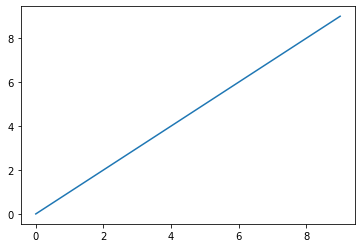

In [1]:
import shutil, os
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(10))

In [2]:
import detectron2
from detectron2.data import DatasetCatalog,MetadataCatalog
from inference import *
from detectron2.utils.visualizer import Visualizer
import cv2
from PIL import Image

try:
    DatasetCatalog.register("rpd_valid", grab_valid)
except:
    print('Already registered.')
    #do nothing
try:
    DatasetCatalog.register("rpd_train", grab_train)
except:
    print('Already registered.')
    #do nothing
try:
    MetadataCatalog.get("rpd_valid").thing_classes = ["rpd"]
except:
    print('Already registered.')
    #do nothing
try:
    MetadataCatalog.get("rpd_train").thing_classes = ["rpd"]   
except:
    print('Already registered.')
    #do nothing

(496, 1024, 3)


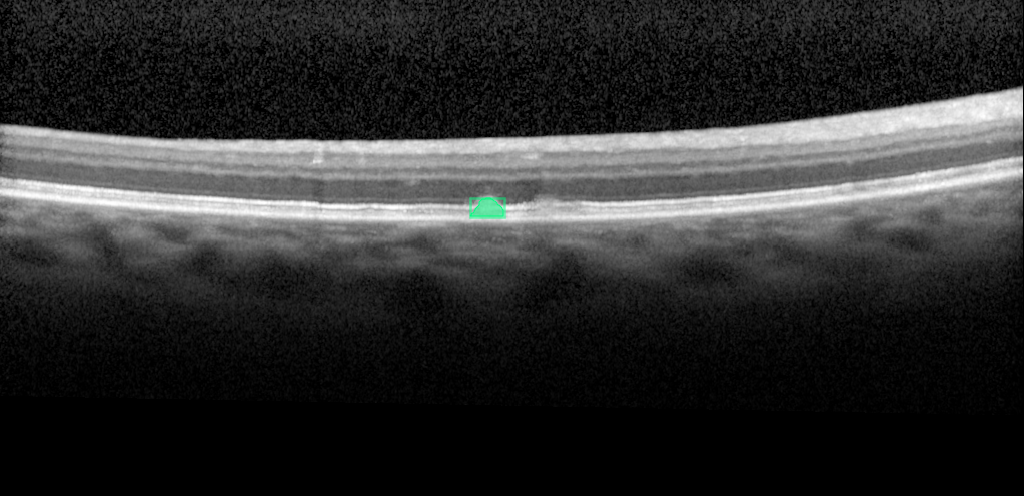

In [154]:
dat = data[8] #gt
im = cv2.imread(dat['file_name']) #input to model
bboxes = [ddict['bbox'] for ddict in dat['annotations']]
BBoxes = detectron2.structures.Boxes(bboxes)
BBoxes = detectron2.structures.BoxMode.convert(BBoxes.tensor,from_mode=1,to_mode=0) #1= XYXY, 2 = XYWH
segs = [ddict['segmentation'] for ddict in dat['annotations']]

v = Visualizer(im, MetadataCatalog.get("rpd_valid"), scale=1.0)
result_image = v.overlay_instances(boxes=BBoxes,masks=segs).get_image()
img = Image.fromarray(result_image)
print(im.shape)
img

In [3]:
#predict
cfg = get_cfg()
cfg.merge_from_file('configs/working')
#really low iou for nms in order to separate out lesions
cfg.merge_from_list(["MODEL.WEIGHTS", "output/model_0005999.pth",
                     "MODEL.ROI_HEADS.NMS_THRESH_TEST",".05",
                     "MODEL.ROI_HEADS.SCORE_THRESH_TEST",".5"])
#print(cfg.dump())  # print formatted configs
print(cfg.MODEL.ROI_HEADS.dump())
print(cfg.MODEL.WEIGHTS)


BATCH_SIZE_PER_IMAGE: 512
IN_FEATURES:
- p2
- p3
- p4
- p5
IOU_LABELS:
- 0
- 1
IOU_THRESHOLDS:
- 0.5
NAME: StandardROIHeads
NMS_THRESH_TEST: 0.05
NUM_CLASSES: 1
POSITIVE_FRACTION: 0.25
PROPOSAL_APPEND_GT: true
SCORE_THRESH_TEST: 0.5

output/model_0005999.pth


In [4]:
#build model
from detectron2.modeling import build_model
model = build_model(cfg)  # returns a torch.nn.Module
from detectron2.checkpoint import DetectionCheckpointer
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS);  # load a file, usually from cfg.MODEL.WEIGHTS
model.eval(); #set model in evaluation mode

In [5]:
from detectron2.data import build_detection_test_loader
myloader = build_detection_test_loader(cfg,"rpd_valid")

In [6]:
from detectron2.evaluation import COCOEvaluator
myeval = COCOEvaluator("rpd_valid",tasks={'bbox'},output_dir = 'output/results')

In [45]:
from detectron2.evaluation import inference_on_dataset
eval_results2 = inference_on_dataset(model,myloader,myeval)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.170
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.104
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0

In [7]:
def get_all_inputs_outputs():
    with torch.no_grad():
        for data in myloader:
            yield data, model(data)
        
gen = get_all_inputs_outputs()
data = DatasetCatalog.get('rpd_valid')

In [55]:
inputs, outputs = next(gen)
print('Predicted instances: {}'.format(len(outputs[0]['instances'])))
print('Input image dict keys:',inputs[0].keys())
gt_data = next(item for item in data if (item['image_id'] == inputs[0]['image_id']))
print('Input annotations keys:',gt_data.keys())
print('Ground truth instances:',len(gt_data['annotations']))


Predicted instances: 1
Input image dict keys: dict_keys(['file_name', 'height', 'width', 'image_id', 'image'])
Input annotations keys: dict_keys(['file_name', 'height', 'width', 'image_id', 'annotations'])
Ground truth instances: 0


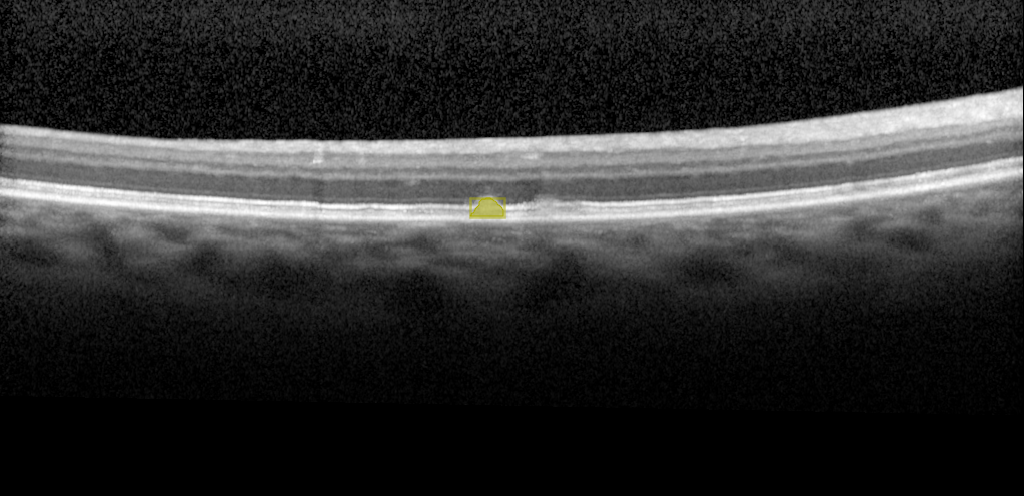

In [40]:
#plot input annotations
im = inputs[0]['image'].permute(1,2,0)
bboxes = [ddict['bbox'] for ddict in gt_data['annotations']]
BBoxes = detectron2.structures.Boxes(bboxes)
BBoxes = detectron2.structures.BoxMode.convert(BBoxes.tensor,from_mode=1,to_mode=0) #1= XYXY, 2 = XYWH
segs = [ddict['segmentation'] for ddict in gt_data['annotations']]

v = Visualizer(im, MetadataCatalog.get("rpd_valid"), scale=1.0)
result_image = v.overlay_instances(boxes=BBoxes,masks=segs).get_image()
img = Image.fromarray(result_image)
img

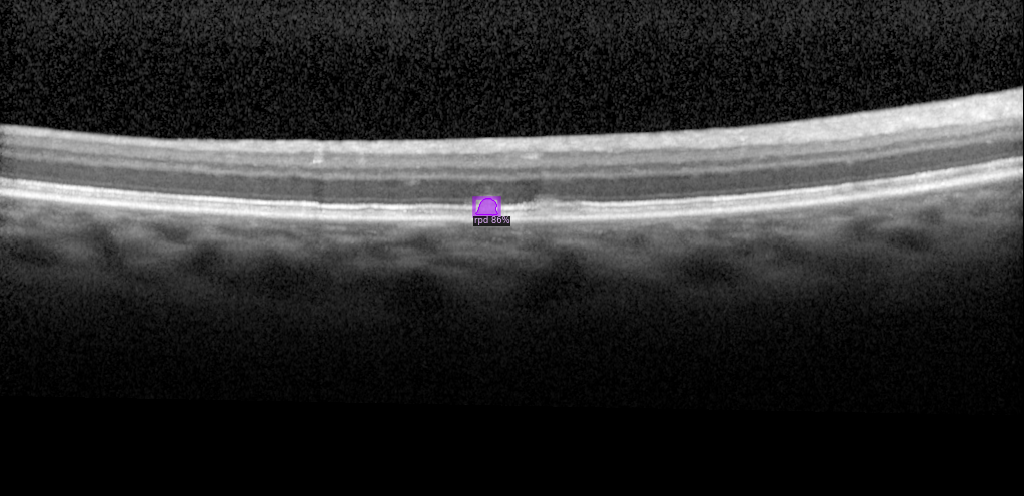

In [41]:
v2 = Visualizer(im, MetadataCatalog.get("rpd_valid"), scale=1.0)
v2._default_font_size = 14
result_model = v2.draw_instance_predictions(outputs[0]['instances'].to('cpu')).get_image()
img_model = Image.fromarray(result_model)
img_model

In [56]:
myeval.reset()
myeval.process(inputs,outputs)
eval_result = myeval.evaluate(inputs[0]['image_id']);
eval_result

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ 

OrderedDict([('bbox',
              {'AP': nan,
               'AP50': nan,
               'AP75': nan,
               'APs': nan,
               'APm': nan,
               'APl': nan})])

In [57]:
cocoDt = myeval._coco_api.loadRes(os.path.join(myeval._output_dir,'coco_instances_results.json'))


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [29]:
MetadataCatalog.get('rpd_valid').json_file

'output/results/rpd_valid_coco_format.json'

In [58]:
from pycocotools.cocoeval import COCOeval
mycoco = COCOeval(myeval._coco_api,cocoDt,iouType ='bbox')

In [59]:
mycoco.params.iouThrs = [.5]
#mycoco.params.recThrs = [0,.5,.75,1]
mycoco.params.maxDets = [100]
mycoco.params.imgIds=[inputs[0]['image_id']]

mycoco.evaluate()
mycoco.accumulate()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).


In [60]:
eval_data = mycoco.evalImgs
eval_data
#eval_data[36]

[{'image_id': '101113_OS_oct-023.png',
  'category_id': 0,
  'aRng': [0, 10000000000.0],
  'maxDet': 100,
  'dtIds': [1],
  'gtIds': [],
  'dtMatches': array([[0.]]),
  'gtMatches': array([], shape=(1, 0), dtype=float64),
  'dtScores': [0.5867145657539368],
  'gtIgnore': array([], dtype=float64),
  'dtIgnore': array([[False]])},
 {'image_id': '101113_OS_oct-023.png',
  'category_id': 0,
  'aRng': [0, 1024],
  'maxDet': 100,
  'dtIds': [1],
  'gtIds': [],
  'dtMatches': array([[0.]]),
  'gtMatches': array([], shape=(1, 0), dtype=float64),
  'dtScores': [0.5867145657539368],
  'gtIgnore': array([], dtype=float64),
  'dtIgnore': array([[False]])},
 {'image_id': '101113_OS_oct-023.png',
  'category_id': 0,
  'aRng': [1024, 9216],
  'maxDet': 100,
  'dtIds': [1],
  'gtIds': [],
  'dtMatches': array([[0.]]),
  'gtMatches': array([], shape=(1, 0), dtype=float64),
  'dtScores': [0.5867145657539368],
  'gtIgnore': array([], dtype=float64),
  'dtIgnore': array([[ True]])},
 {'image_id': '101113_

(1, 101, 1, 4, 1)


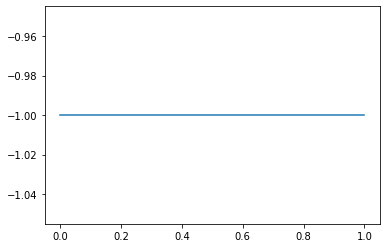

In [61]:
print(mycoco.eval['precision'].shape) #[T,R,K,A,M] parameter dims
# "imgIds": [all] N img ids to use for evaluation 
# "catIds": [all] K cat ids to use for evaluation 
# "iouThrs": [.5:.05:.95] T=10 IoU thresholds for evaluation #this many PR curves to average over
# "recThrs": [0:.01:1] R=101 recall thresholds for evaluation #count precision at these points on curve
# "areaRng": [all,small,medium,large] A=4 area ranges for evaluation 
# "maxDets": [1 10 100] M=3 thresholds on max detections per image
pr = mycoco.eval['precision'][0, #iouthresh
                         :, #recall level
                         0, #catagory
                         0, #area range
                         0] #max detections per image
rc = mycoco.params.recThrs
plt.plot(rc,pr)

In [5]:
pred = DefaultPredictor(cfg)
outputs = pred(im)["instances"].to("cpu")
th = 0.1
filtered = outputs[outputs.scores > th]

/root/miniconda3/envs/detectron/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370128159/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


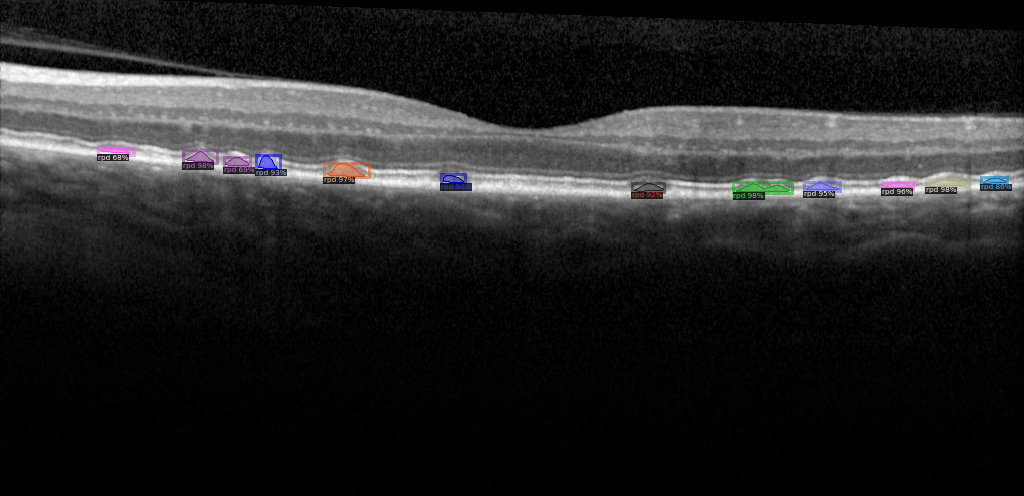

In [37]:
v2 = Visualizer(im, MetadataCatalog.get("rpd_valid"), scale=1.0)
v2._default_font_size = 12
result_model = v2.draw_instance_predictions(filtered).get_image()
img_model = Image.fromarray(result_model)
img_model